In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib import dates as md

In [2]:
# to disable GPU support
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# fix/hack for CUDA: https://github.com/tensorflow/tensorflow/issues/41987
#                    https://www.gitmemory.com/issue/tensorflow/tensorflow/41993/668082420
os.environ['TF_CUDNN_RESET_RND_GEN_STATE'] = '1'

# code inspired from:
# 1. https://www.kaggle.com/mineshjethva/timeseries-anomaly-detection-using-rnn-autoencoder/comments
# 2. https://www.kaggle.com/koheimuramatsu/industrial-machine-anomaly-detection

# 1. Read Raw Data

## 1.1. Artificial Data

In [3]:
url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
small_noise_url = url_root + small_noise_url_suffix
df_small_noise = pd.read_csv(small_noise_url)

daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
daily_jumpsup_url = url_root + daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(daily_jumpsup_url)

<AxesSubplot:>

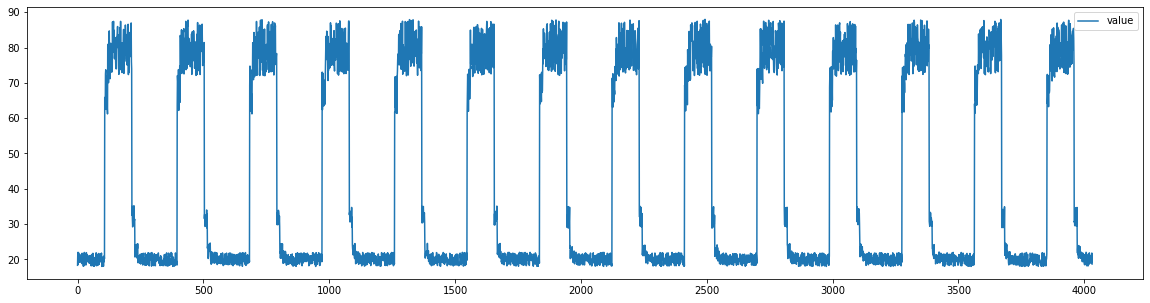

In [4]:
df_small_noise.plot(figsize=(20,5))

## 1.2. Real Data

In [5]:
aws_url_suffix = "realKnownCause/ec2_request_latency_system_failure.csv"
aws_latency_data_url = url_root + aws_url_suffix
df_aws_latency = pd.read_csv(aws_latency_data_url)

<AxesSubplot:>

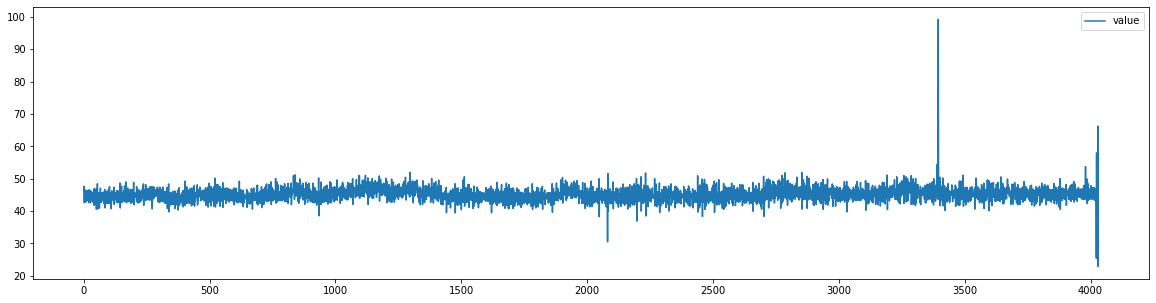

In [6]:
df_aws_latency.plot(figsize=(20,5))

# 2. Data Gaps

In [7]:
data_gaps = [
    [
        "2014-04-08 00:00:00.000000",
        "2014-04-09 00:00:00.000000"
    ]
]

In [8]:
df_small_noise_gap1 = (df_small_noise['timestamp'] > data_gaps[0][0]) & (df_small_noise['timestamp'] <= data_gaps[0][1])
df_small_noise_before_gap = (df_small_noise['timestamp'] < data_gaps[0][0])

In [9]:
# df_small_noise_with_gap = df_small_noise.loc[~df_small_noise_gap1]

In [10]:
df_small_noise_cpy = df_small_noise.copy()
df_small_noise_cpy.loc[df_small_noise_gap1] = np.nan

<AxesSubplot:>

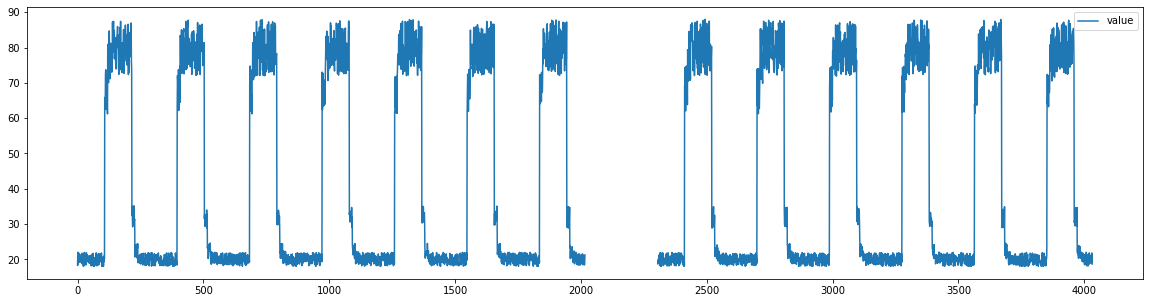

In [11]:
df_small_noise_cpy.plot(figsize=(20,5))

## 2.1. Simple

### 2.1.1. Back fill

In [12]:
df_small_noise_reconstructed_bfill = df_small_noise_cpy.fillna(method='bfill')

<AxesSubplot:>

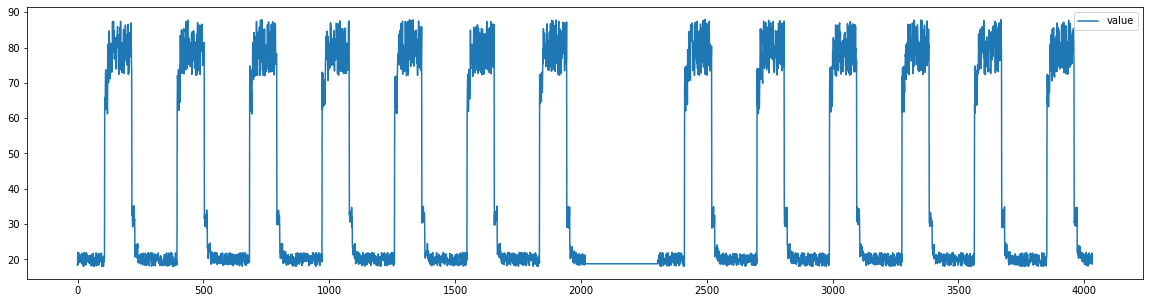

In [13]:
df_small_noise_reconstructed_bfill.plot(figsize=(20,5))

In [14]:
err_bfill = np.mean(abs(df_small_noise.loc[df_small_noise_gap1].value - df_small_noise_reconstructed_bfill.loc[df_small_noise_gap1].value))

In [15]:
print(err_bfill)

23.64317307853889


### 2.1.2. Forward Fill

In [16]:
df_small_noise_reconstructed_ffill = df_small_noise_cpy.fillna(method='ffill')

<AxesSubplot:>

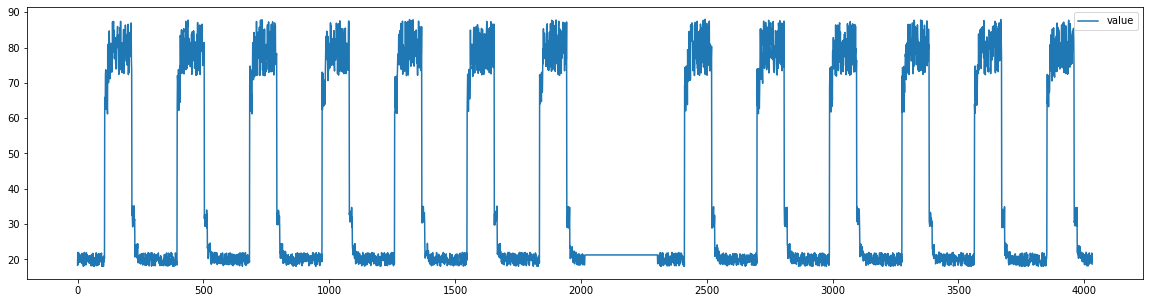

In [17]:
df_small_noise_reconstructed_ffill.plot(figsize=(20,5))

In [18]:
err_ffill = np.mean(abs(df_small_noise.loc[df_small_noise_gap1].value - df_small_noise_reconstructed_ffill.loc[df_small_noise_gap1].value))

In [19]:
print(err_ffill)

22.558939025837496


### 2.1.3. Fill Median

In [20]:
df_small_noise_cpy.value.mean()

42.44676851304624

In [21]:
df_small_noise_reconstructed_mean = df_small_noise_cpy.fillna(df_small_noise_cpy.value.mean())

<AxesSubplot:>

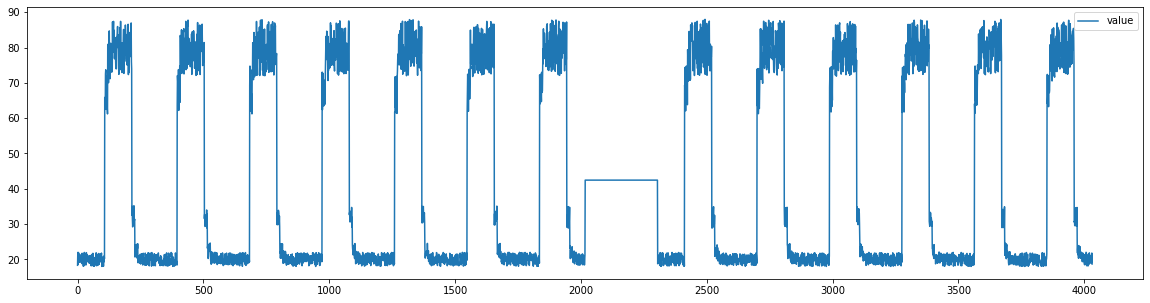

In [22]:
df_small_noise_reconstructed_mean.plot(figsize=(20,5))

In [23]:
err_mean = np.mean(abs(df_small_noise.loc[df_small_noise_gap1].value - df_small_noise_reconstructed_mean.loc[df_small_noise_gap1].value))

In [24]:
print(err_mean)

26.735139218152533


### 2.1.4. Interpolate

In [32]:
df_small_noise_i = df_small_noise_cpy.set_index('timestamp')
df_small_noise_i.index = df_small_noise.index
df_small_noise_i.index = pd.to_datetime(df_small_noise_i.index)

In [43]:
df_small_noise_reconstructed_interpolate = df_small_noise_i.interpolate(method='nearest', order=5)

<AxesSubplot:>

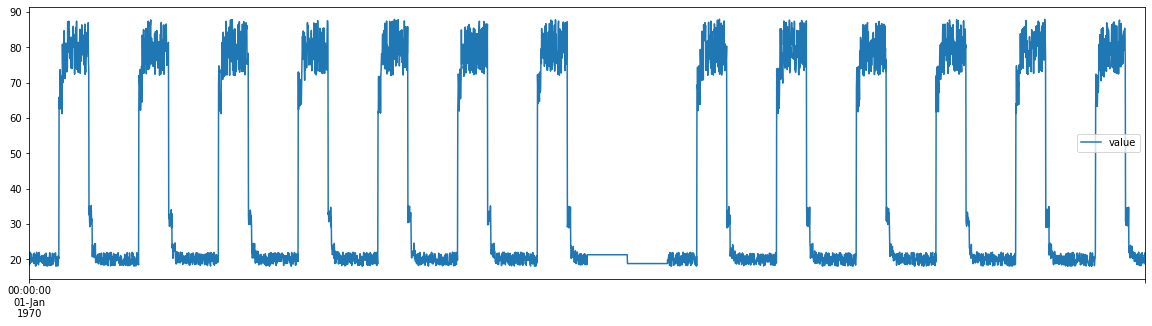

In [44]:
df_small_noise_reconstructed_interpolate.plot(figsize=(20,5))

### 2.1.5. Predictive Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
train_x = [x for x in df_small_noise_cpy.value.loc[~df_small_noise_gap1]]

In [ ]:
model = ARIMA(train_x)
model_fit = model.fit()

In [ ]:
df_small_noise_cpy.value.loc[df_small_noise_gap1].shape

In [ ]:
gap_fill = []
for idx in range(df_small_noise_cpy.value.loc[df_small_noise_gap1].shape[0]):
    output = model_fit.forecast()
    yhat = output[0]
    gap_fill.append(yhat)
    print(output)

In [ ]:
df_small_noise_reconstructed_arima = df_small_noise_cpy.copy()

In [ ]:
df_small_noise_reconstructed_arima.value.loc[df_small_noise_gap1] = yhat

In [ ]:
df_small_noise_reconstructed_arima.plot(figsize=(20,5))

In [ ]:
# # univariate lstm example
# from numpy import array
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
#     X, y = list(), list()
#     for i in range(len(sequence)):
#         # find the end of this pattern
#         end_ix = i + n_steps
#         # check if we are beyond the sequence
#         if end_ix > len(sequence)-1:
#             break
#         # gather input and output parts of the pattern
#         seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
#         X.append(seq_x)
#         y.append(seq_y)
#     return array(X), array(y)
 
# # define input sequence
# raw_seq = train_x #, 30, 40, 50, 60, 70, 80, 90]

# # choose a number of time steps
# n_steps = 50

# # split into samples
# X, y = split_sequence(raw_seq, n_steps)

# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# X = X.reshape((X.shape[0], X.shape[1], n_features))

# # define model
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# # fit model
# model.fit(X, y, epochs=200)

In [ ]:
# # demonstrate prediction
# x_input = array([20.1, 20.2, 20.3])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [ ]:
# gap_fill = []
# vals_before = list(df_small_noise_cpy.loc[df_small_noise_before_gap].value)[-n_steps:]
# print(gap_fill)
# for idx in range(df_small_noise_cpy.value.loc[df_small_noise_gap1].shape[0]):
#     pred_input = array(vals_before[-n_steps:]) if len(gap_fill) < 50 else array(gap_fill[-n_steps:])
#     pred_input = pred_input.reshape((1, n_steps, n_features))
#     p = model.predict(pred_input)
#     gap_fill.append(p[0][0])
#     print('{}. output: {}'.format(idx, p))